# Analyzing data using ARIMA model
The workflow is inspired by: [time-series-forecast-study-python-annual-water-usage-baltimore](https://machinelearningmastery.com/time-series-forecast-study-python-annual-water-usage-baltimore/)

# 1. Environment

In [1]:
# check the versions of key python libraries
# scipy
import scipy
print('scipy: %s' % scipy.__version__)
# numpy
import numpy as np
print('numpy: %s' % np.__version__)
# matplotlib
import matplotlib
print('matplotlib: %s' % matplotlib.__version__)
# pandas
import pandas as pd
print('pandas: %s' % pd.__version__)
# statsmodels
import statsmodels
print('statsmodels: %s' % statsmodels.__version__)
# scikit-learn
import sklearn
print('sklearn: %s' % sklearn.__version__)

scipy: 1.5.4
numpy: 1.19.5
matplotlib: 3.3.4
pandas: 1.1.5
statsmodels: 0.12.2
sklearn: 0.24.2


In [2]:
import src.data.water_depth as water_depth
import matplotlib.pyplot as plt
plt.style.use('dark_background')
plt.rcParams["figure.figsize"] = (18,6)

# 2. Problem Description
The problem is to predict the water depth at Sundsbykile bay, based on previous hydrological measurements. Sundsbykile is a nice place for kayaking, but the water is sometimes too shallow, so it is a good idea to keep track and predict the future water depth.
<iframe src="https://www.google.com/maps/embed?pb=!1m14!1m8!1m3!1d8441.337776113218!2d11.702945!3d58.066815!3m2!1i1024!2i768!4f13.1!3m3!1m2!1s0x0%3A0x87594ce6a5a8bcd3!2sSundsby%20kile!5e0!3m2!1ssv!2sse!4v1621274725851!5m2!1ssv!2sse" width="600" height="450" style="border:0;" allowfullscreen="" loading="lazy"></iframe>

# Data
The water depth data is collected using the following REST API: [opendata-download-ocobs.smhi.se](https://opendata-download-ocobs.smhi.se/). Data for the latest 24 hours is available through this API. In order to get more data, water depth data has been collected daily for some time.

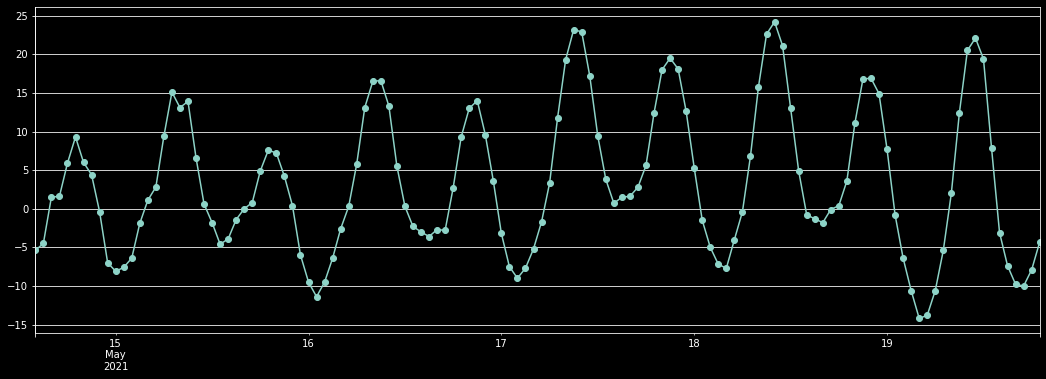

In [3]:
data_depth = water_depth.get()
fig,ax=plt.subplots()
fig.set_size_inches(18,6)
data_depth.plot(style='o-', ax=ax)
ax.grid()

# 4. Test Harness
We must develop a test harness to investigate the data and evaluate candidate models.

This involves two steps:

Defining a Validation Dataset.
Developing a Method for Model Evaluation.

## 3.1 Validation Dataset

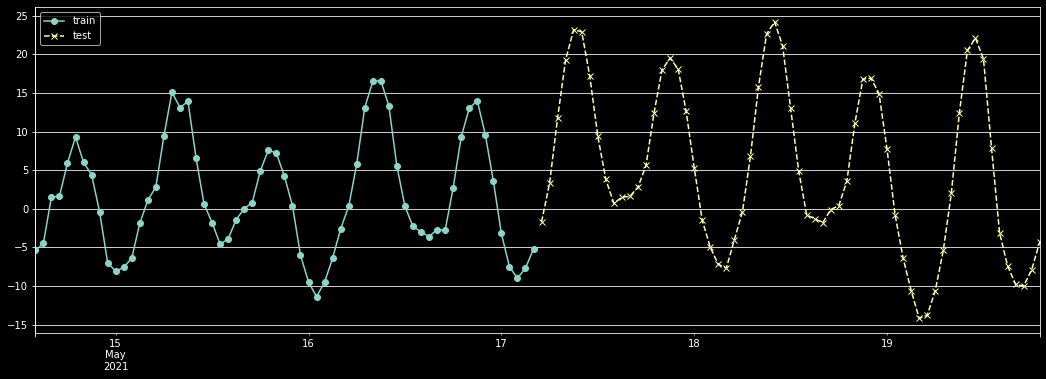

In [26]:
split_ratio = 1/2
index_split = int(len(data_depth)*split_ratio)
y_train = data_depth.iloc[0:-index_split]
y_test = data_depth.iloc[-index_split:]

fig,ax=plt.subplots()
fig.set_size_inches(18,6)
y_train.plot(style='o-', ax=ax, label='train')
y_test.plot(style='x--', ax=ax, label='test')

ax.grid()
ax.legend()

# 5. Persistence
The first step before getting bogged down in data analysis and modeling is to establish a baseline of performance.

This will provide both a template for evaluating models using the proposed test harness and a performance measure by which all more elaborate predictive models can be compared.

The baseline prediction for time series forecasting is called the naive forecast, or persistence.

This is where the observation from the previous time step is used as the prediction for the observation at the next time step.

We can plug this directly into the test harness defined in the previous section.

The complete code listing is provided below.

In [27]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import euclidean_distances
class NaiveForecast(BaseEstimator, ClassifierMixin):
    
    def fit(self, history):
        # Check that X and y have correct shape
        # Store the classes seen during fit
        #self.classes_ = unique_labels(history)
        self.y_ = history
        
        # Return the classifier
        return self
    
    def predict(self, X):
        # Check is fit had been called
        check_is_fitted(self)
        # Input validation
        #X = check_array(X)

        y_pred = np.ones(len(X))*self.y_[-1]

        return y_pred

In [28]:
naive_forcast = NaiveForecast()
naive_forcast.fit(history=y_train)

NaiveForecast()

In [29]:
def roll_predict(model, y_train, y_test):

    history = [x for x in y_train]
    predictions = list()
    for i in range(len(y_test)):

        # predict
        model_fit = model.fit(history)

        yhat = model_fit.predict(y_test)[0]
        predictions.append(yhat)
        # observation
        obs = y_test[i]
        history.append(obs)

    y_pred = pd.Series(index=y_test.index, data=predictions)
    return y_pred

In [30]:
from sklearn.metrics import mean_squared_error
y_pred_naive = roll_predict(model=naive_forcast, y_train=y_train, y_test=y_test)
np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred_naive))

5.3440814317529215

In [31]:
def plot_pred(y_train, y_test, y_pred):

    fig,ax=plt.subplots()

    y_train.plot(style='o-', ax=ax, label='train')
    y_test.plot(style='x--', ax=ax, label='test')

    y_pred.plot(style='s:', ax=ax, label='predict')

    ax.grid()
    ax.legend()



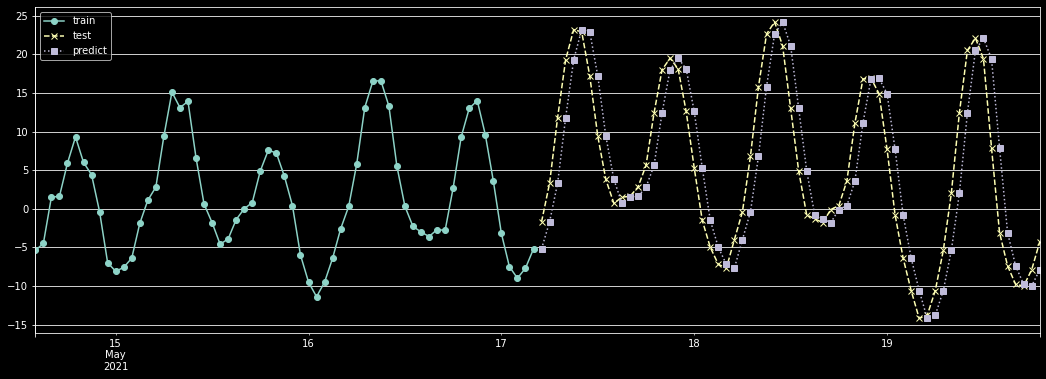

In [32]:
plot_pred(y_train=y_train, y_test=y_test, y_pred=y_pred_naive)

# 7. ARIMA Models
In this section, we will develop Autoregressive Integrated Moving Average or ARIMA models for the problem.

We will approach modeling by both manual and automatic configuration of the ARIMA model. This will be followed by a third step of investigating the residual errors of the chosen model.

As such, this section is broken down into 3 steps:

1. Manually Configure the ARIMA.
2. Automatically Configure the ARIMA.
3. Review Residual Errors.

## 6.1 Manually Configured ARIMA

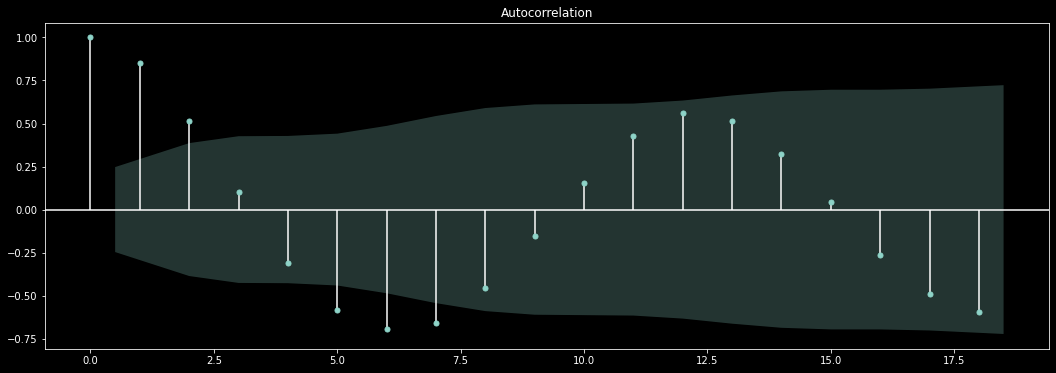

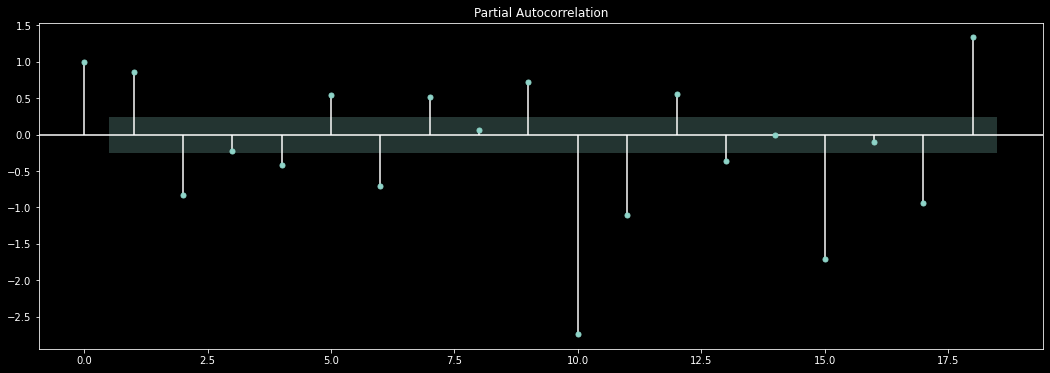

In [33]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

fig,ax=plt.subplots()
plot_acf(y_train, ax=ax);

fig,ax=plt.subplots()
plot_pacf(y_train,ax=ax);


In [34]:
from statsmodels.tsa.arima.model import ARIMA
# walk-forward validation

def train_predict(y_train, y_test, order=(2,0,0)):
    history = [x for x in y_train]

    predictions = list()
    for i in range(len(y_test)):

        # predict
        model = ARIMA(history, order=order)
        model_fit = model.fit()

        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        # observation
        obs = y_test[i]
        history.append(obs)

    y_pred = pd.Series(index=y_test.index, data=predictions)

    return y_pred


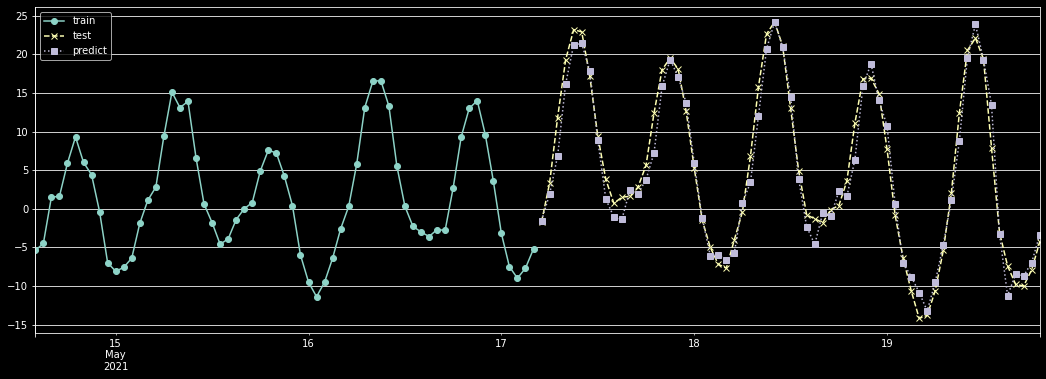

In [35]:
plot_pred(y_train=y_train, y_test=y_test, y_pred=train_predict(y_train=y_train, y_test=y_test))

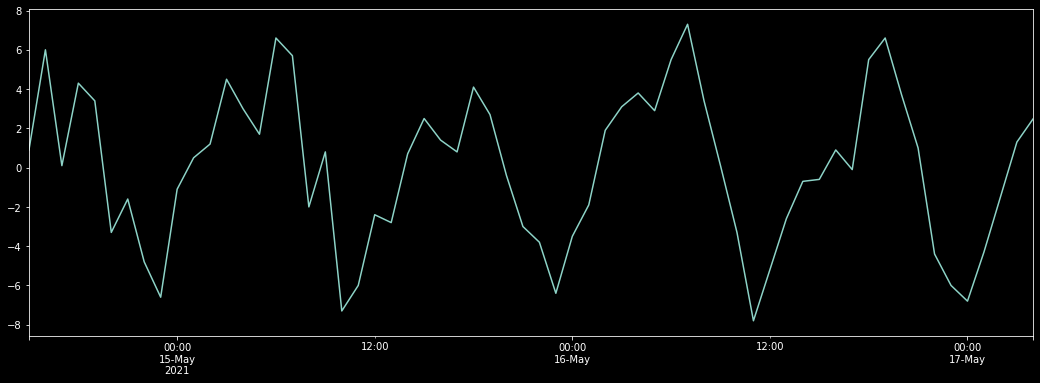

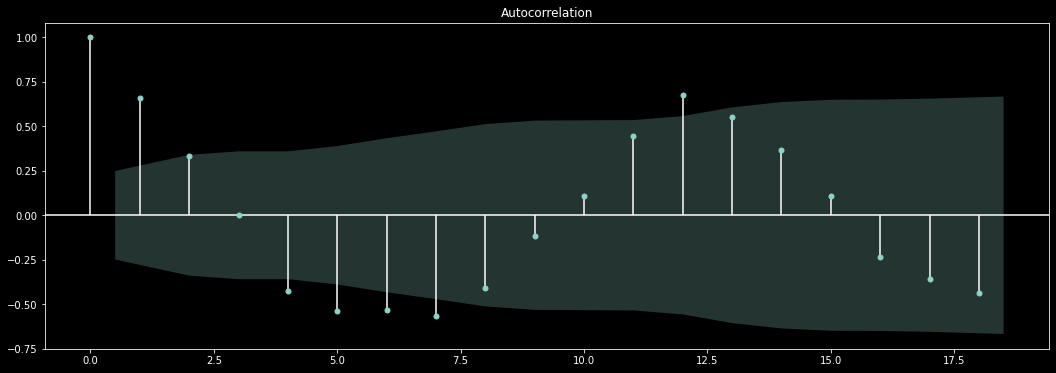

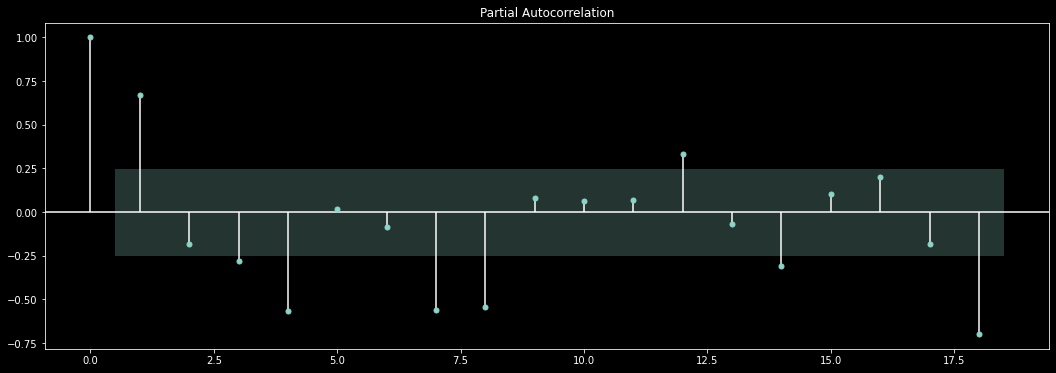

In [36]:
y_train_ = y_train.diff().dropna()
y_test_ = y_test.diff().dropna()

y_train_.plot()

plot_acf(y_train_);

plot_pacf(y_train_);

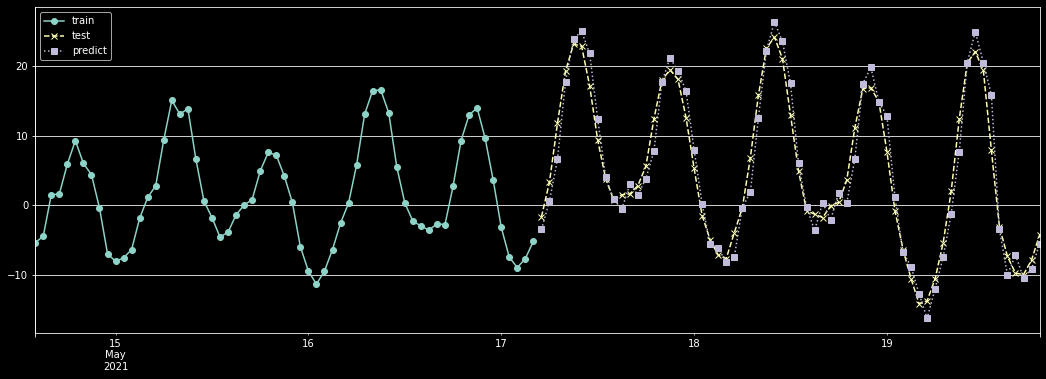

In [37]:
plot_pred(y_train=y_train, y_test=y_test, y_pred=train_predict(y_train=y_train, y_test=y_test, order=(2,1,0)))

In [44]:
order=(3,0,0)
model = ARIMA(y_train, order=order)
model_fit = model.fit()

y_pred = model_fit.forecast()

/Users/martinalexandersson/Dev/water_depth/venv/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/Users/martinalexandersson/Dev/water_depth/venv/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/Users/martinalexandersson/Dev/water_depth/venv/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


In [45]:
y_pred

2021-05-17 05:00:00+00:00   -0.958685
Freq: H, dtype: float64

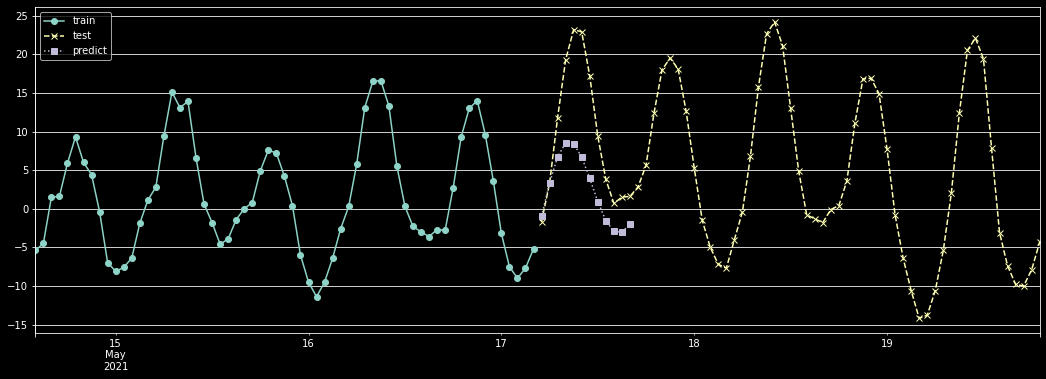

In [46]:
plot_pred(y_train=y_train, y_test=y_test, y_pred=model_fit.forecast(12))

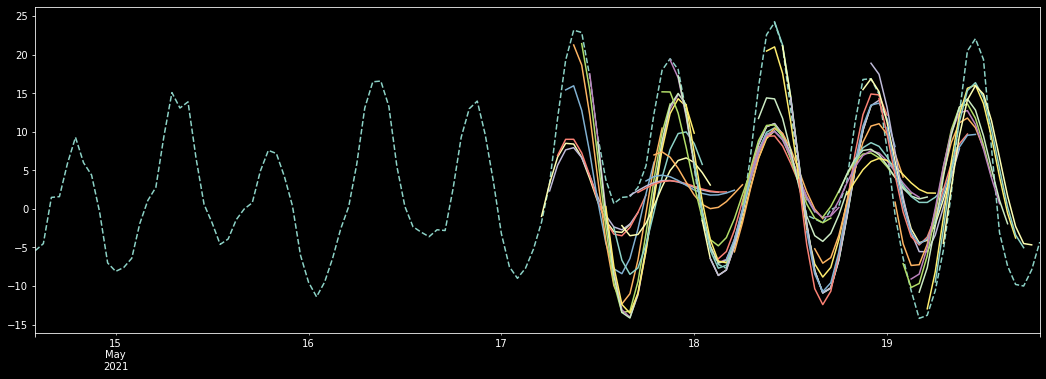

In [61]:
order=(3,0,0)

steps = y_test[0:-12]
history = y_train.to_list()

fig,ax=plt.subplots()

data_depth.plot(style='--', ax=ax)
ax.grid()

rmse=[]
for i,step in enumerate(steps):

    model = ARIMA(history, order=order)
    model_fit = model.fit()
    
    y_test_12 = y_test[i:i+12]
    y_pred_12 = pd.Series(model_fit.forecast(12), index=y_test_12.index)
    y_pred_12.plot(style='-', ax=ax, label='predict')
    rmse.append(np.sqrt(mean_squared_error(y_true=y_test_12, y_pred=y_pred_12)))

    history.append(step)

rmse=pd.Series(rmse, index=steps.index)

<AxesSubplot:>

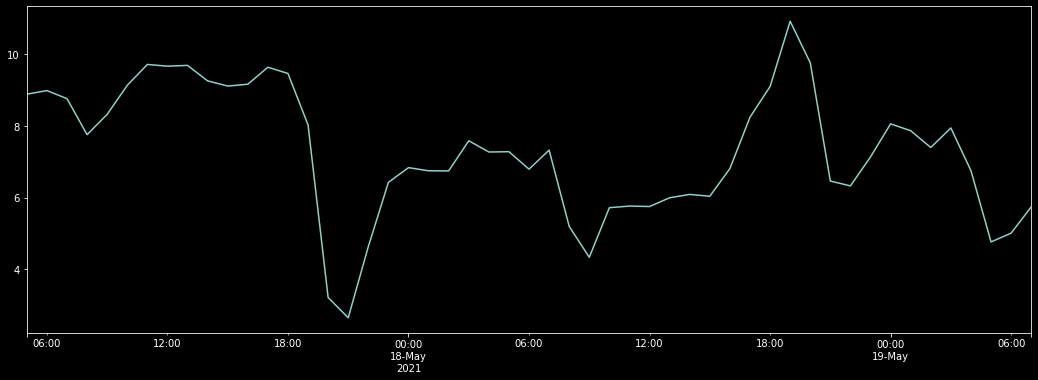

In [62]:
rmse.plot()

In [63]:
rmse.mean()

7.298061397118668

In [64]:
def fit_evaluate(order=(3,0,0)):
    

    steps = y_test[0:-12]
    history = y_train.to_list()

    rmse=[]
    for i,step in enumerate(steps):

        model = ARIMA(history, order=order)
        model_fit = model.fit()

        y_test_12 = y_test[i:i+12]
        y_pred_12 = pd.Series(model_fit.forecast(12), index=y_test_12.index)
        rmse.append(np.sqrt(mean_squared_error(y_true=y_test_12, y_pred=y_pred_12)))

        history.append(step)

    rmse=pd.Series(rmse, index=steps.index)
    return rmse.mean()

In [65]:
fit_evaluate()

7.298061397118668

In [70]:
rmse_best = fit_evaluate(order=(0,0,0))

In [71]:

for p in range(0,5):
    for d in range(0,3):
        for q in range(0,5):
            rmse = fit_evaluate(order=(p,d,q))
            if rmse < rmse_best:
                rmse_best = rmse
                best = (p,d,q)

timization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/martinalexandersson/Dev/water_depth/venv/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/martinalexandersson/Dev/water_depth/venv/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/martinalexandersson/Dev/water_depth/venv/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/martinalexandersson/Dev/water_depth/venv/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/martinalexandersson/Dev/water_depth/venv/lib/p

LinAlgError: LU decomposition error.

In [73]:
fit_evaluate(best)

/Users/martinalexandersson/Dev/water_depth/venv/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/martinalexandersson/Dev/water_depth/venv/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/martinalexandersson/Dev/water_depth/venv/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/martinalexandersson/Dev/water_depth/venv/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/martinalexandersson/Dev/water_depth/venv/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarnin

6.821264891329384

/Users/martinalexandersson/Dev/water_depth/venv/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/martinalexandersson/Dev/water_depth/venv/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/martinalexandersson/Dev/water_depth/venv/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/martinalexandersson/Dev/water_depth/venv/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/martinalexandersson/Dev/water_depth/venv/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarnin

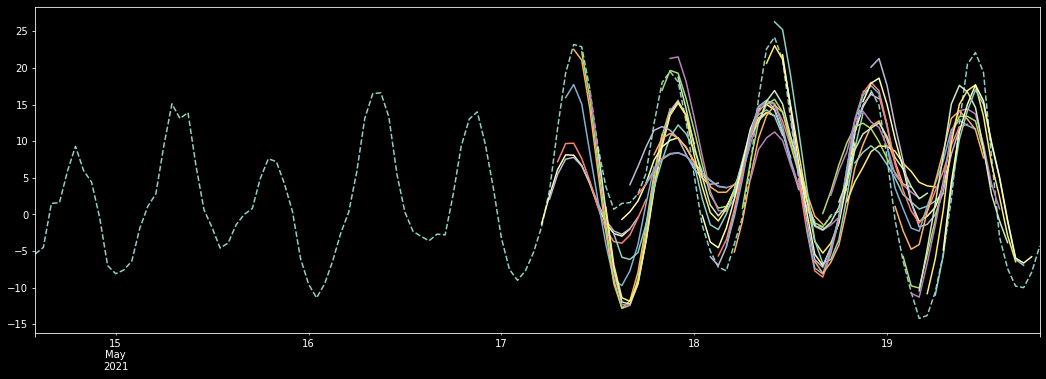

In [74]:
order=best

steps = y_test[0:-12]
history = y_train.to_list()

fig,ax=plt.subplots()

data_depth.plot(style='--', ax=ax)
ax.grid()

rmse=[]
for i,step in enumerate(steps):

    model = ARIMA(history, order=order)
    model_fit = model.fit()
    
    y_test_12 = y_test[i:i+12]
    y_pred_12 = pd.Series(model_fit.forecast(12), index=y_test_12.index)
    y_pred_12.plot(style='-', ax=ax, label='predict')
    rmse.append(np.sqrt(mean_squared_error(y_true=y_test_12, y_pred=y_pred_12)))

    history.append(step)

rmse=pd.Series(rmse, index=steps.index)

In [75]:
best

(4, 1, 3)

In [85]:
model = ARIMA(data_depth, order=best)
model_fit = model.fit()

end = data_depth.index[-1] +pd.Timedelta(12, unit='h')
t_pred = pd.date_range(start=data_depth.index[-1], end=end, freq='h') 

y_pred_12 = pd.Series(model_fit.forecast(12), index=t_pred)

/Users/martinalexandersson/Dev/water_depth/venv/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/Users/martinalexandersson/Dev/water_depth/venv/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/Users/martinalexandersson/Dev/water_depth/venv/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/Users/martinalexandersson/Dev/water_depth/venv/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


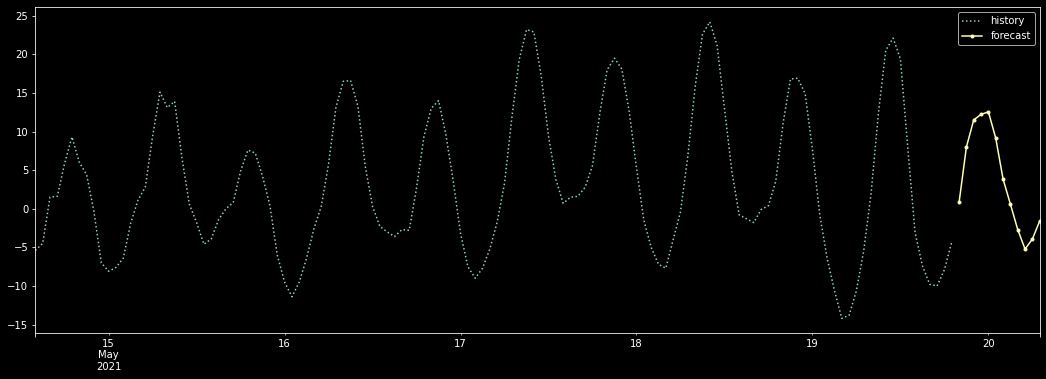

In [90]:
fig,ax=plt.subplots()
data_depth.plot(style=':', ax=ax, label='history')
y_pred_12.plot(style='.-', ax=ax, label='forecast')
ax.legend()